In [51]:
%pylab inline
pylab.rcParams['figure.figsize'] = 12,5

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Based on the characterization of the Axon-Hillock design performed in AHOsc_Char.ipynb, we have one good solution for large currents and two possible solutions for small currents.  This notebook will be used to help us debug and optimize these circuits until we have a promising final solution.  Hopefully, once we've optimized these circuits, we will be able to use them for the current proposed ADC (an Analog to Time to Digital Converter, ATDC).

The other more pressing reason for forking this notebook from the previous notebook was to clean up the code and shorten the notebook length.

In [52]:
import os
import sys
from scipy.optimize import leastsq
from pylab import *
import csv
import mpld3

# Global Functions and Variables

In [16]:
sampleTime = 20e-6

folderPath="/home/noza/work/Braindrop/CDB/BDTests/AHOsc_test/Measurements/"

# This readFile to takes the average value of every other column
def readFile(filePath):
    data = genfromtxt(filePath, dtype=float, delimiter=",", skip_header=1)
    sampleFreqs = data[:,1::2]
    return nanmean(sampleFreqs, axis=0)

# Generic plotting tool that takes a temperature value to also print in the label
def plotGen(Xs, Ys, temp, pltRange, plotType='.-', 
            plotLog=False, ttl='Default Title', xlbl='xLabel', ylbl='yLabel', color=(1,0,0,1)):
    rangeX, rangeY = pltRange[0], pltRange[1]    
    lenYs = len(Ys)
    if plotLog:
        loglog(Xs[:lenYs],Ys, plotType, label=str(temp)+"C", color=color)
    else:
        plot(Xs[:lenYs],Ys, plotType, label=str(temp)+"C", color=color)
    xlabel(xlbl)
    ylabel(ylbl)
    title(ttl)
    xlim(rangeX)
    ylim(rangeY)

In [17]:
# These functions define the equation used to fit the data points.
def linfit(xdata, params):
    m, b, I0 = params
    return m/(xdata-I0) + b

def linfitErr(params, xdata, ydata):
    m, b, I0 = params
    return ydata - (m/(xdata-I0) + b)

In [84]:
# Getter functions to convert a string to a value for handling units
def getTScaleVal(TScaleFactor):
    if TScaleFactor in ['n', 'ns']:
        TScale = 1e-9
        TLbl = '$T(ns)$'
    elif TScaleFactor in ['u', 'us']:
        TScale = 1e-6
        TLbl = '$T(\mu s)$'
    elif TScaleFactor in ['m', 'ms']:
        TScale = 1e-3
        TLbl = '$T(ms)$'
    elif TScaleFactor <= 1:
        TScale = 1
        TLbl = '$T(s)$'
    return TScale, TLbl

def getIScaleVal(IScaleFactor):
    if IScaleFactor in ['f', 'fa', 'fA']:
        IScale = 1e-15
        ILbl = '$\\frac{1}{I_{in}} (\\frac{1}{fA})$'
    elif IScaleFactor in ['p', 'pa', 'pA']:
        IScale = 1e-12
        ILbl = '$\\frac{1}{I_{in}} (\\frac{1}{pA})$'
    elif IScaleFactor in ['n', 'na', 'nA']:
        IScale = 1e-9
        ILbl = '$\\frac{1}{I_{in}} (\\frac{1}{nA})$'
    return IScale, ILbl

In [60]:
# Plot T (period) vs 1/Iin (inverse input current)   
def plotLinearityT(curinvIins, curAH_Ts, curTemp, x_th, Ts_th, xMax, yMax, dxMax, dyMin, dyMax,
                   xLbl='$\\frac{1}{I_{in}} (\\frac{1}{nA})$',yLbl='$T(\mu s)$',):
    # Determine Color Value
    curTempScale = float(curTemp)/50
    col = (curTempScale,0,1-curTempScale,1)
    
    subplot(1,2,1)
    # Plot on a linear scale
    plotGen(curinvIins, curAH_Ts, curTemp, [[0,xMax], [0,yMax]],
            plotType = '.',
            ttl='Ring Oscillator Period',
            xlbl=xLbl,
            ylbl=yLbl,
            color=col)
    
    # Plot the linear fit
    plot(1./x_th, Ts_th, '-',color=col)
    
    subplot(1,2,2)
    # Plot the derivative
    derivTs = diff(curAH_Ts)/diff(curinvIins)
    #plotGen(curinvIins[1:], derivTs, curTemp, [[0,max(curinvIins[1:])],[min(derivTs),max(derivTs)]],
    plotGen(curinvIins[1:], derivTs, curTemp, [[0,dxMax],[dyMin,dyMax]],
            plotType='-',
            ttl='Derivative of Ring Oscillator Period',
            xlbl=xLbl,
            ylbl='$\\frac{dT}{d\\frac{1}{I_{in}}}$',
            color=col)

# filePath: path to the data file (include the folderPath and fileName)
# Iins: input current in amps
# IScaleFactor: desired input current units
#     (it will apply the appropriate scaling value to Iins (still in Amps))
# TScaleFactor: desired period units
#     (it will apply the appropriate scaling value to time (originally in seconds))
def plotLinearity(filePath, Iins, IScaleFactor='pA', TScaleFactor='ms', Lims=None, dLims=None):
    # Read the input file and extract the frequencies
    AH_Freqs = array(readFile(filePath))
    
    TScale, TLbl = getTScaleVal(TScaleFactor)
    AH_Ts = (1./AH_Freqs)/TScale
    
    IScale, ILbl = getIScaleVal(IScaleFactor)
    scaledIins = Iins/IScale
    invIins = 1./scaledIins
    
    Lims[0] = xLim = max(Lims[0], max(invIins))
    Lims[1] = yLim = max(Lims[1], max(AH_Ts))
    dLims[0] = dxMax = max(dLims[0], max(invIins[1:]))
    dLims[1] = dyMin = min(dLims[1], min(diff(AH_Ts)/diff(invIins)))
    dLims[2] = dyMax = max(dLims[2], max(diff(AH_Ts)/diff(invIins)))

    x_th = linspace(min(scaledIins),max(scaledIins), num=10000)
    sol = leastsq(linfitErr, (1.1, 0.001, 0), (scaledIins, AH_Ts))
    Ts_th = linfit(x_th, sol[0])

    plotLinearityT(invIins, AH_Ts, curTemp, x_th, Ts_th,
                   xLim, yLim, dxMax, dyMin, dyMax, ILbl,TLbl)
    return AH_Ts, sol[0], Lims, dLims

# Plots a series of time points and their y-value at those times
def plotTimeSeries(xVals, yVals, clr=(1,0,0,1), 
                   ttl='', xLbl='', yLbl='',
                   xMin=0, xMax=10, yMin=0, yMax=10):
    if xMin==None:
        xMin = min(xVals)
    if xMax==None:
        xMax = max(xVals)
    if yMin==None:
        yMin = min(yVals)
    if yMax==None:
        yMax = max(yVals)
    plot(xVals,yVals, color=clr)
    xlabel(xLbl)
    ylabel(yLbl)
    title(ttl)
    xlim([xMin,xMax])
    ylim([yMin,yMax])

In [85]:
# Calculate the Relative RMSE of data compared to the fit
def calcRRMSE(Iins, Ts, Params, IScaleFactor):
    IScale, ILbl = getIScaleVal(IScaleFactor)
    scaledIins = Iins/IScale
    thTs = linfit(scaledIins, Params)
    #print (Ts - thTs)
    se = (Ts - thTs)**2
    resSampVar = sum(se)/(len(se)-1)
    #print 'Residual Variance: {}'.format(resSampVar)
    rms = sqrt(mean(thTs**2))
    rrmse = sqrt(resSampVar/rms)
    #print 'Relative RMSE: {:%}'.format(rrmse)
    return rrmse

In [137]:
# This function will print out the percentage of the overall period that is attributed to the inverter delay.
def percPeriodbyDelay(TsAsFuncOfIin, curIins, avgLoopDelay, curTemps):
    print 'Percent of overall period taken by delay from feedback buffer delay'
    print '{:>5s}\t\t'.format("Iins") + "%s"%'\t'.join(curTemps)
    for i, curTs in enumerate(TsAsFuncOfIin):
        #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
        Iins_fA = curIins[i]/10**-15
        percDelay = avgLoopDelay*1e3/curTs
        foo = list()
        for i, curPDelay in enumerate(percDelay):
            #print '\t{:^6.3%}'.format(percDelay[i])
            foo.append('\t{:^6.3%}'.format(percDelay[i]))
        #print foo
        print '{:>5.0f} fA'.format(Iins_fA) + ''.join(foo)

# Calculate the percentage variance that results from the variation in temperature.
# curTemps: When a list of temperatures is passed in, this argument does two things
#    1) It is used as a flag to tell the function to print each periods 
#    deviation from the mean as a signed percentage of the mean.  (It only does this
#    if the number of curTemps is the same as the number of curTs)
#    2) It passes in the array of temperatures to print individual values corresponding
#    temperature 
def percVariancebyTemp(TsAsFuncofIin,curIins,curTemps=None,IScaleFactor='pA'):
    IScale, ILbl = getIScaleVal(IScaleFactor)
    print
    if curTemps:
        print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error(Negative values => Value smaller than mean)")
    else:
        print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
    for i, curTs in enumerate(TsAsFuncOfIin):
        #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
        scIins = curIins[i]/IScale
        re = (max(curTs)-min(curTs))/mean(curTs)  # re = relative error
        print '{:>6.3f} {}\t{:^12.3%}'.format(scIins, IScaleFactor, re)
        
        if curTemps and len(curTemps)==len(curTs):
            for j, curT in enumerate(curTs):
                ire = (curT-mean(curTs))/mean(curTs)   # individual relative error
                print '\t{:>4.1f} C\t{:^12.3%}'.format(curTemps[j], ire)

# Calculate the percentage variance that results from the variation in temperature.
# vals: matrix of dimensions (numIins x numTemps)
# idealVal: the ideal value you want to compare the measurements to
# curIins: array of Iin values (in Amps) of length numIins
# curTemps: array of temperature values (in C) of length numTemps
def percVarReltoIdeal(measVals,idealVal,curIins,curTemps, IScaleFactor):
    IScale, ILbl = getIScaleVal(IScaleFactor)
    print
    for i, curVals in enumerate(measVals):
        print '{:>5s}\t\t{:^2s}\t{:^12s}'.format("Iins", "Temp", "Percent Error")
        for j, curVal in enumerate(curVals[i]):
            scIins = curIins[i]/IScale
            re = (curVal-idealVal)/idealVal
            print '{:>6.3f} {}\t{:^2s}\t{:^12.3%}'.format(scIins, IScaleFactor, curTemps[j], re)
            

This just gets the value of the swept parameters, $I_{in}$ and Temp (if the temperature was swept)

In [102]:
paramFile = open(folderPath+"SweptParams.csv")
for i, row in enumerate(csv.reader(paramFile)):
    if i == 0:
        Temps = [int(i) for i in array(row[1:])]
        print "Temps: ", Temps
    elif i==1:
        Iins = array(double(row[1:]))
        print "Iins: ", Iins
    else:
        print "Too many rows"

Temps:  [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
Iins:  [  1.00000000e-11   2.15443469e-11   4.64158883e-11   1.00000000e-10
   2.15443469e-10   4.64158883e-10   1.00000000e-09   2.15443469e-09
   4.64158883e-09   1.00000000e-08]


# ThinOxide FETs for Large Currents using Source Switches
Below, you will find the final results from AHOsc_Char for the large current sensing AH circuit.  This circuit was made using simple mirrors and ThinFET inverters.  There are three inverters, the first two to create the oscillating waveform and the third to act as the source switches.

These measurements were made without buffers controlling the gates of the current sources.  This sweep also includes sweeping over temperature, so that we can see how this AH circuit will operate, in it's non-ideal, but realistic, configuration.

To get a good idea of how well the fit approximates the data, we also want to calculate the RMSE of the data.  This will give us an idea of what to expect in the actual circuit when it is built.  We can see this in the "Relative RMSE" calculation, calculated using the calcRRMSE function.

The results below also quantify the percentage difference in the period as we sweep over temperatures for the AH circuit analyzed above.

The inverters are sized as shown below: 

    Thin PFET: 90n x 30n
    Thin NFET: 80n x 30n
   
Our circuit's requirements for large input currents (10pA to 10nA) is to be able to have a maximum period length of $20\mu s$ for the smallest input current and a <1% error in period measurements over $50^{\circ}C$.

AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp0C.csv
Temp:  0	Relative RMSE: 0.393283%	Params: [  4.61411108e-01   2.27275800e-02  -2.17002737e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp5C.csv
Temp:  5	Relative RMSE: 0.391934%	Params: [  4.62080355e-01   2.24899703e-02  -2.19749705e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp10C.csv
Temp: 10	Relative RMSE: 0.391342%	Params: [  4.62739016e-01   2.22970201e-02  -2.22033688e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp15C.csv
Temp: 15	Relative RMSE: 0.390903%	Params: [  4.63386917e-01   2.21253037e-02  -2.24812420e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp20C.csv
Temp: 20	Relative RMSE: 0.388236%	Params: [  4.64042210e-01   2.19091406e-02  -2.28111216e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp25C.csv
Temp: 25	Relative RMSE: 0.388610%	Params: [  4.64676839e-01   2.17802025e-02  -2.30761649e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp30C.csv
Temp: 30	Relative RMSE: 0.387069%	Params: [  4.65304609e-01   2.16171052e-0

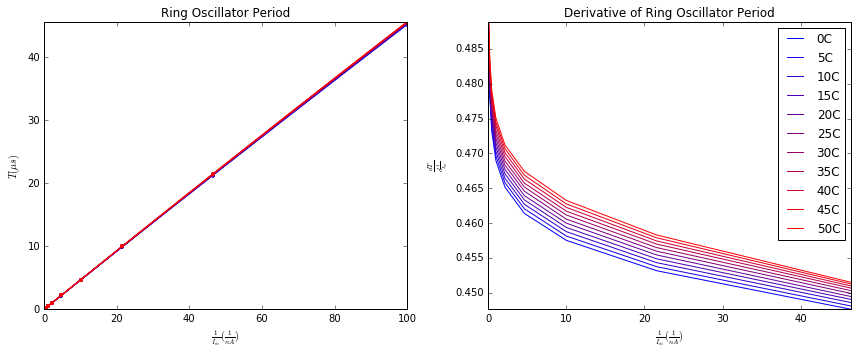

In [132]:
allTs = []
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in Temps:
    fileName = "AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, Iins, 
                                        IScaleFactor='nA', TScaleFactor='us',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    print 'Temp: {:>2}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(Iins, curTs,
                                                                       curFitParams, IScaleFactor='nA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, Iins, IScaleFactor='nA')
#percVariancebyTemp(TsAsFuncOfIin, Iins, Temps, IScaleFactor='nA')
#mpld3.display()    # Display the plots in interactive mode

# ThickOxide Inverter for Slow Input Currents
For smaller currents, we found in AHOsc_Char that we can change the inverters, in the feedback chain of inverters, to ThickFET transistors.  The reason we think we can get away with using ThickFETs for smaller currents is because the inverter's gain will still be much faster than the capacitor's charging speed, and as such the non-linearity introduced by the ThickFET will be a much smaller proportion of the switching time of the oscillator.  The sweep will range from 10fA to 10pA (to cover the remaining 2 orders of magnitude).

In this section we compare two biasing circuits (to set the "current source" values).  We are going to investigate Kwabena's Mirror (previously known as the Vcap-based biasing) compared to Ben's Mirror.  We want to analyze these mirrors in more detail to find out which one behaves more ideally over temperature for our input currents.  If we are able to do this, then we will have a better understanding of where our problems are coming from and will therefore be able to make a more informed decision regarding which architecture to use (assuming we can optimize the speeds further).

_Note: To speed up simulation time, I am going to continue to do abridged sweeps of temperatures and $I_{in}$.  Temperature will be swept from $0^{\circ}C-50^{\circ}C$ in 3 equal steps, and input current will have 5 logarithmic steps from 100fA to 10pA._

Our circuit's requirements for small input currents (100fA to 10pA) is to be able to have a maximum period length of 1ms for the smallest input current and a <1% error in period measurements over $50^{\circ}C$.

Get our sweep parameters from the data files

In [133]:
paramFile = open(folderPath+"SweptParams_SmallIins_QuickSweep.csv")
for i, row in enumerate(csv.reader(paramFile)):
    if i == 0:
        LessTemps = [int(i) for i in array(row[1:])]
        print "Temps: ", LessTemps
    elif i==1:
        SmallIins = array(double(row[1:]))
        print "Iins: ", SmallIins
    else:
        print "Too many rows"

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-13   3.16227766e-13   1.00000000e-12   3.16227766e-12
   1.00000000e-11]


## Bias Circuit Analysis
In our bias circuits, we essentially have two problems to solve/balance in order to ensure that input current is accurately mirrored to set the two current sources (the charging and discharging currents).  The first problem is that we want to ensure that we don't run out of headroom while setting any of the current values.  The second problem is to ensure that none of the transistors unintentionally pinch the current in the circuit.  This second problem could arise from having the $V_{ds}$ value of a transistor become too small.  We want to do all of this while keeping our current consumption to a minimum, keeping temperature variance in check and making the circuit fast enough.

### Kwabena's Mirror ($V_{cap}$-based biasing)
In this circuit, we use the $V_{cap}$ signal to control a common gate amplifier.  This allows the mirror's $V_{ds}$ to be set to a much closer value (similar to a complex mirror).

To simplify the thinking, as a baseline for this bias, I have all of the transistors set as 1W and 1L, except P11 and N20, as shown in the schematic below.

We make the bias transistors N20 and P11 longer, thereby making it so that the current source pulling $I_b$ doesn't require as much current.  This will help with the power consumption of the circuit.  This was shown to work well in the previous notebook, as shown in the test results copied from that section.  As such, we will use this as the baseline for this section.

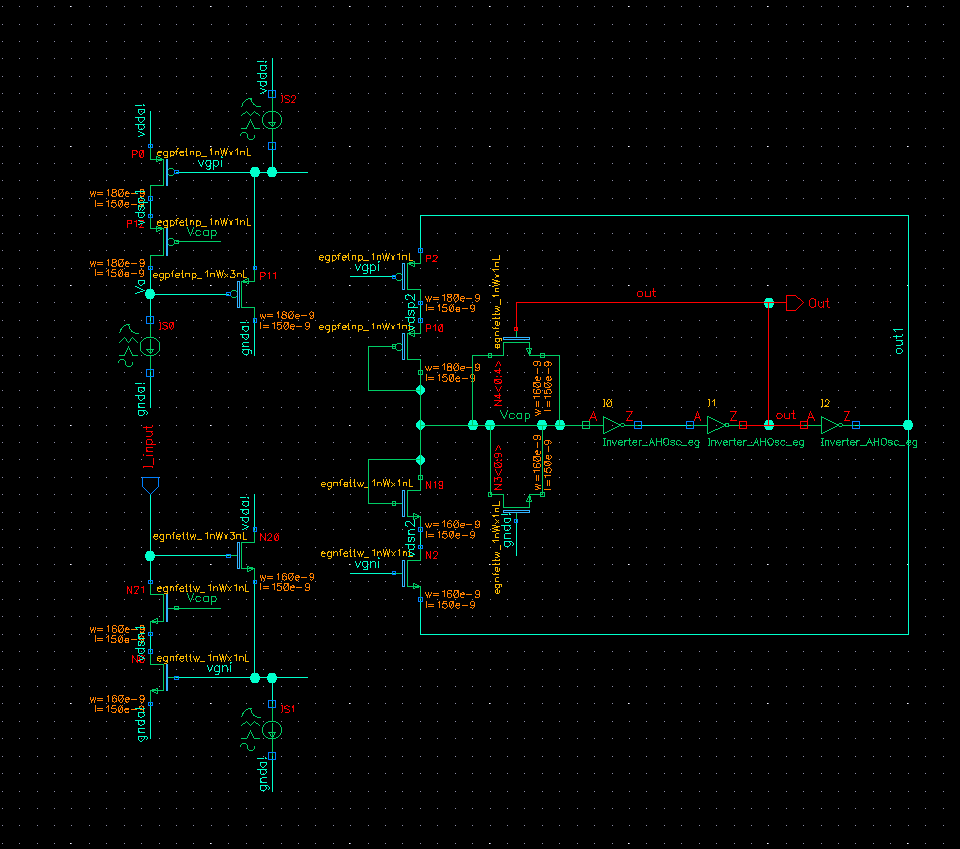

In [297]:
from IPython.display import Image
filePath = "/home/noza/work/Braindrop/CDB/BDTests/AHOsc_test/Measurements/SchematicImages/"
Image(filePath + "AHConfig_VcapBasedCS_LongerFdbkTxr_NoBuf_C1_10x_C2_5x.png", width=800)

AH_VcapBasedCS_LongFdbkTxrs/AH_Inv_FreqMeas_Temp0C_NoBuf_Ib500p_C1_10x_C2_5x.csv
Temp: 0	Relative RMSE: 0.017124%	Params: [  1.05027435e+00   1.46251178e-03  -1.13565112e-04]
AH_VcapBasedCS_LongFdbkTxrs/AH_Inv_FreqMeas_Temp25C_NoBuf_Ib500p_C1_10x_C2_5x.csv
Temp: 25	Relative RMSE: 0.012516%	Params: [  1.04987150e+00   1.03024389e-03  -1.61982796e-04]
AH_VcapBasedCS_LongFdbkTxrs/AH_Inv_FreqMeas_Temp50C_NoBuf_Ib500p_C1_10x_C2_5x.csv
Temp: 50	Relative RMSE: 0.011778%	Params: [  1.05011206e+00   7.61542628e-04  -8.55899064e-04]

 Iins		Percent Error
 0.100 pA	   0.760%   
 0.316 pA	   0.269%   
 1.000 pA	   0.168%   
 3.162 pA	   0.296%   
10.000 pA	   0.479%   

 Iins		Percent Error(Negative values => Value smaller than mean)
 0.100 pA	   0.760%   
	 0.0 C	   0.284%   
	25.0 C	   0.193%   
	50.0 C	  -0.476%   
 0.316 pA	   0.269%   
	 0.0 C	   0.111%   
	25.0 C	   0.046%   
	50.0 C	  -0.158%   
 1.000 pA	   0.168%   
	 0.0 C	   0.088%   
	25.0 C	  -0.008%   
	50.0 C	  -0.080%   
 3.162 pA	

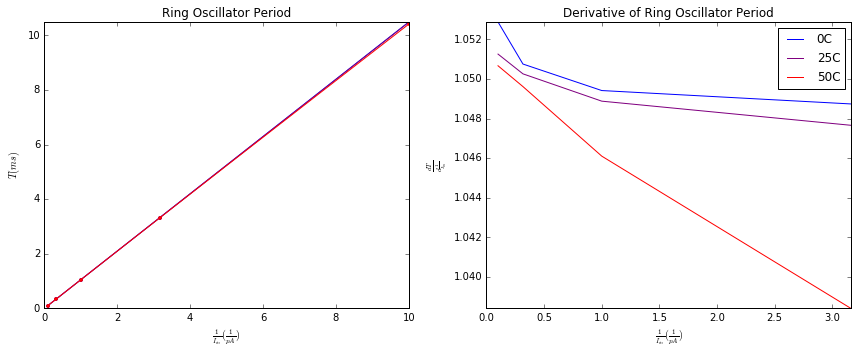

In [138]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in sorted(LessTemps):
    fileName = "AH_VcapBasedCS_LongFdbkTxrs/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C_NoBuf_Ib500p_C1_10x_C2_5x.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

### Ben's Mirror
In this circuit, instead of using a normal complex mirror, we use Ben's modified version, where he adds a bias to tune the $V_{ds}$ values of the mirroring transistors.  This circuit helps buy more headroom because now we can lower the $V_{out}$ (or $V_{cap}$ equivalent) node to 250mV when mirroring current into the PFET portion of the circuit.

In our previous notebook we saw that a buffered version of Ben's mirror works well, but that once we made this unbuffered, the results were terrible.

A schematic of the simplified (everything is 1W, 1L, and min-sized) version of Ben's Mirror is shown below.  We will compare the biasing circuitry of this design to Kwabena's mirror in the next section.

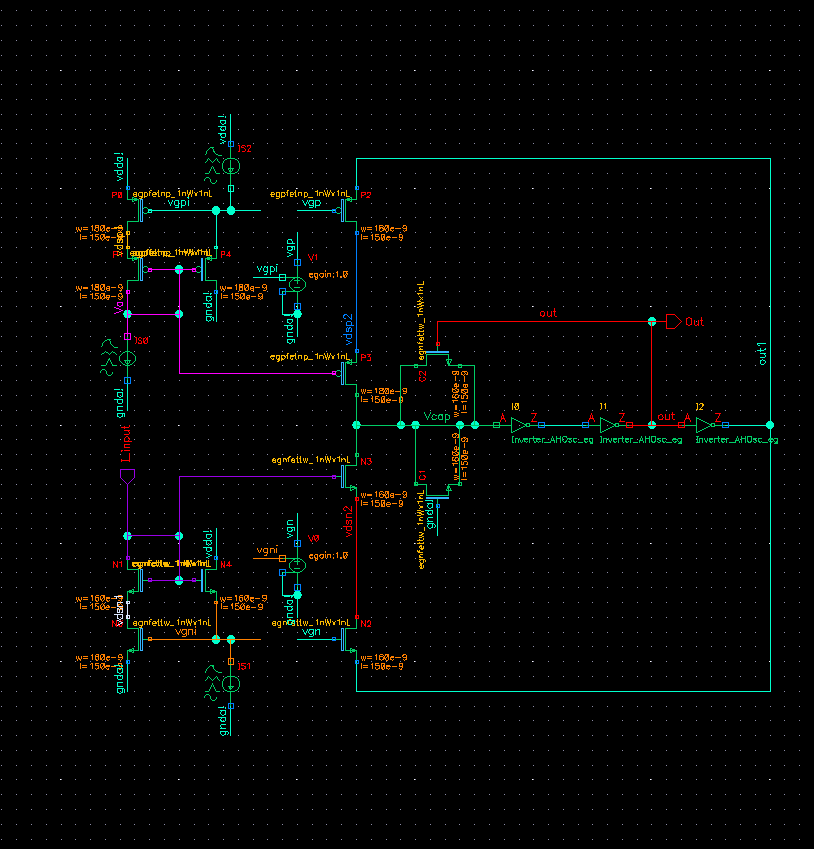

In [53]:
from IPython.display import Image
filePath = "/home/noza/work/Braindrop/CDB/BDTests/AHOsc_test/Measurements/SchematicImages/"
Image(filePath + "AHConfig_BensMirror_Simp_C1_1x_C2_1x_Iin1x.png", width=800)

## Final Verification of Two Bias system
From our bias current analysis, we found that Kwabena's mirror operates ever so slightly better than Ben's mirror on average.  As a result, the simulations below show some of our final verifications to determine the best KB mirror-based AH design to use in our actual circuit.  Once this is shown below to have sub-1% error, then I will try to remove the dicharging circuitry and substitute it with a really large bias, to make the circuitry behave in an asymmetric manner.  This asymmetry will hopefully buy us the 2x speed up we want without sacrificing any error, and will also ideally help with some of the error introduced at small currents due to gate leakage in the NFETs

### Full range (10 fA to 10pA) baseline

In [139]:
paramFile = open(folderPath+"SweptParams_SmallIins_10fAto10pA.csv")
for i, row in enumerate(csv.reader(paramFile)):
    if i == 0:
        LessTemps = [int(i) for i in array(row[1:])]
        print "Temps: ", LessTemps
    elif i==1:
        SmallIins = array(double(row[1:]))
        print "Iins: ", SmallIins
    else:
        print "Too many rows"

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]


In [140]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in sorted(LessTemps):
    fileName = "AH_Final/AH_FreqMeas_Temp"+str(curTemp)+"C_NoBuf_Ib100p_C1_1x_C2_1x.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

AH_Final/AH_FreqMeas_Temp0C_NoBuf_Ib100p_C1_1x_C2_1x.csv


IOError: /home/noza/work/Braindrop/CDB/BDTests/AHOsc_test/Measurements/AH_Final/AH_FreqMeas_Temp0C_NoBuf_Ib100p_C1_1x_C2_1x.csv not found.